Congratulations! You have just been hired as a data scientist at "The ByteBlasters", EPFL’s amateur baseball club. The team's manager, Mr. Russo, an eccentric millionaire with an innovative plan to dominate the Swiss baseball league, believes hiring left-handed pitchers (the people who throw the ball) will likely boost the team's performance. Yet, he is concerned about money, as he heard left-handed pitchers have historically earned more!

He tasked you to investigate this "sinister" issue and gave you some openly available data on the birthplace of this beautiful, dynamic sport --- the US.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
%matplotlib inline
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
import seaborn as sns

---

# Task 1 : Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

1. You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
2. When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

---

**1.1 —** Load the `People`, `Salaries`, and `Pitching` dataframes. Then:
- Filter the `Salaries`, and `Pitching` dataframes to remove all data after the year 2010.
- For the `Salaries` dataframe drop all duplicate salaries for players in a given year. In other words, if a player (uniquely identified by `PlayerID`) has multiple salaries in a year (`yearID`), keep the first occurence in the dataframe and drop the remaining.
- Calculate the size of each dataframe. 

Make [deep copies](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html) of all dataframes as you filter them.

Hints:
- 2007 should be included in the data.
- 2010 should be included in the data.
- 2011 should not be included in the data.

In [2]:
data_folder = './data/baseballdatabank-2023/core/'
df_People = pd.read_csv(data_folder + 'People.csv')
df_Salaries = pd.read_csv('./data/baseballdatabank-2023/contrib/Salaries.csv')
df_Pitching = pd.read_csv(data_folder + 'Pitching.csv')
df_People_copy = df_People.copy()

In [3]:
# making deep copy of the dataframes
df_Salaries_copy = df_Salaries.copy()
df_Pitching_copy = df_Pitching.copy()

In [4]:
# extracting all data before 2011 year
df_Salaries = df_Salaries.query('yearID <= 2010')
df_Pitching = df_Pitching.query('yearID <= 2010')

In [5]:
df_Salaries['playerID'].duplicated() # checking if there are duplicated values
df_Salaries.drop_duplicates(subset = 'playerID') # droping duplicates

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000
...,...,...,...,...,...
21432,2010,WAS,NL,detwiro01,400000
21434,2010,WAS,NL,englije01,400000
21442,2010,WAS,NL,mockga01,411000
21447,2010,WAS,NL,stammcr01,402000


In [6]:
print(df_Salaries.size)
print(df_Pitching.size)

107270
1212990


**1.2 —** The `throws` column in the `People` dataframe indicates, for each player, whether they throw with the left ("L") or right hand ("R"). Check what values are in the column and drop rows containing any value that is not "L" or "R," again, make a deep copy when you filter the dataframe.

Hint: Remember NaNs!

In [7]:
df_People = df_People.dropna(axis = 'rows', subset = ['throws'])

# df_People_copy[df_People_copy['throws'].isnull()]

**1.3 —** Merge the `People` dataframe with the `Pitching` dataframe. Your merge should populate the pitching data with statistics about the players. Print the resulting dataframe.

In [8]:
merged_pitching_people  = df_Pitching.merge(df_People, how = 'left',on = 'playerID')
print(merged_pitching_people)

        playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  \
0      bechtge01    1871      1    PH1  NaN   1   2   3   3   2  ...   
1      brainas01    1871      1    WS3  NaN  12  15  30  30  30  ...   
2      fergubo01    1871      1    NY2  NaN   0   0   1   0   0  ...   
3      fishech01    1871      1    RC1  NaN   4  16  24  24  22  ...   
4      fleetfr01    1871      1    NY2  NaN   0   1   1   1   1  ...   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...   
40428  zambrca01    2010      1    CHN   NL  11   6  36  20   0  ...   
40429  zieglbr01    2010      1    OAK   AL   3   7  64   0   0  ...   
40430  zimmejo02    2010      1    WAS   NL   1   2   7   7   0  ...   
40431   zitoba01    2010      1    SFN   NL   9  14  34  33   1  ...   
40432  zumayjo01    2010      1    DET   AL   2   1  31   0   0  ...   

         nameLast        nameGiven  weight  height  bats  throws       debut  \
0             NaN              NaN     NaN     NaN   Na

**1.4 —** You realize some of the data for the `throws` column is missing! Estimate the percentage of missing data points per year in that column, and show your estimates in a line plot. Additionally, print what percentage of the data was missing in 1892.

In [9]:
with_nan = merged_pitching_people['yearID'].value_counts().sort_index().values
years =merged_pitching_people['yearID'].drop_duplicates().values
without_nan = merged_pitching_people.dropna(subset = 'throws')['yearID'].value_counts().sort_index().values
df_by_year = pd.DataFrame({'yearID': years, 'throws_with_nan': with_nan, 'throws_without_nan': without_nan })
df_by_year[['throws_with_nan','throws_with_nan']].astype(int)
df_by_year['NaNs'] = df_by_year['throws_with_nan'] - df_by_year['throws_without_nan']
df_by_year['persentage of missing'] = df_by_year['NaNs']/df_by_year['throws_with_nan']*100

Text(0, 0.5, 'persentage of missing')

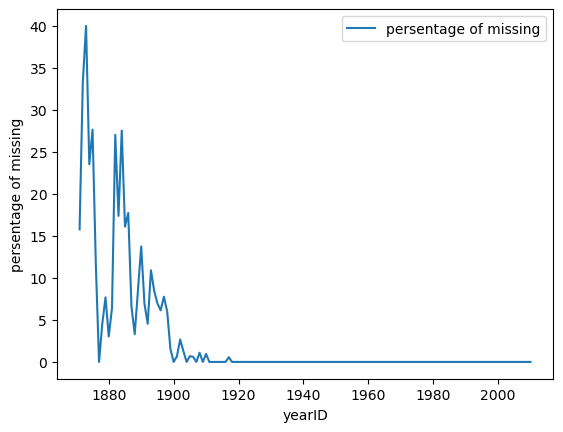

In [10]:
df_by_year[['yearID', 'persentage of missing']].plot(x = 'yearID', y = 'persentage of missing')
plt.ylabel('persentage of missing')

In [11]:
df_by_year[df_by_year['yearID'] == 1892][['yearID', 'persentage of missing']]

,yearID,persentage of missing
21,1892,4.545455


**1.5 —** Filter the dataset you just merged (hereinafter `Pitching-People`) to just contain data from after 1920 (with 1920 included). Do the same with the `Salaries` dataset. Make deep copies of both dataframes as you filter them.



In [12]:
merged_pitching_people_filtered = merged_pitching_people.copy()
merged_pitching_people_filtered =merged_pitching_people_filtered.query('yearID >= 1920')
df_Salaries_filtered = df_Salaries.copy()
df_Salaries_filtered = df_Salaries_filtered.query('yearID >= 1920')
df_Salaries_filtered

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000
...,...,...,...,...,...
21449,2010,WAS,NL,walkety01,650000
21450,2010,WAS,NL,wangch01,2000000
21451,2010,WAS,NL,willijo03,4600000
21452,2010,WAS,NL,zimmejo01,401000


**1.6 —**  Merge the `Pitching-People` dataframe with the `Salaries` dataframe. Your merge should populate the `Pitching-People` dataframe with statistics about the pitchers'salaries across the years. Note that the `Salaries` dataframe contains the salary **per year.** Print the resulting dataframe.

In [13]:
pitching_people_salary = merged_pitching_people_filtered.merge(df_Salaries_filtered, how = 'left', on = ['playerID', 'yearID', 'teamID', 'lgID'])
print(pitching_people_salary)

        playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  \
0      acostjo01    1920      1    WS1   AL   5   4  17   5   4  ...   
1      adamsba01    1920      1    PIT   NL  17  13  35  33  19  ...   
2      alexape01    1920      1    CHN   NL  27  14  46  40  33  ...   
3      altener01    1920      1    DET   AL   0   1  14   1   0  ...   
4      ayersdo01    1920      1    DET   AL   7  14  46  23   8  ...   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...   
33876  zambrca01    2010      1    CHN   NL  11   6  36  20   0  ...   
33877  zieglbr01    2010      1    OAK   AL   3   7  64   0   0  ...   
33878  zimmejo02    2010      1    WAS   NL   1   2   7   7   0  ...   
33879   zitoba01    2010      1    SFN   NL   9  14  34  33   1  ...   
33880  zumayjo01    2010      1    DET   AL   2   1  31   0   0  ...   

              nameGiven  weight  height  bats  throws       debut   finalGame  \
0                  Jose   134.0    66.0     R       R 

**1.7 —** You realize some of the data for the `salary` column is missing! Estimate the percentage of missing data points per year, and show your estimates in a line plot. Additionally, print what percentage of the data was missing in 2002.


In [14]:
salary = pitching_people_salary['yearID'].value_counts().sort_index().values
years =pitching_people_salary['yearID'].drop_duplicates().values
year_salary = pitching_people_salary.loc[:, 'yearID': 'salary']
year_salary['nans'] = year_salary['salary'].isnull()
groupby_year = year_salary.groupby('yearID')['nans'].sum().reset_index(name = 'number of nans')
df_year = pd.DataFrame({'yearID': years, 'salary': salary, 'nan_salary': groupby_year['number of nans'] })
df_year[['salary','nan_salary']].astype(int)
df_year['persentage of missing'] = df_year['nan_salary']/df_year['salary']*100

<Axes: xlabel='yearID'>

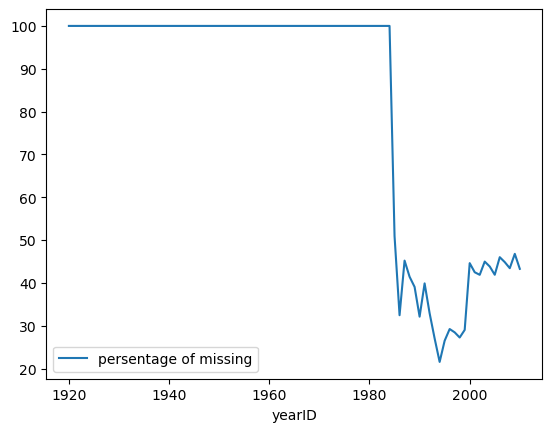

In [15]:
df_year.plot(x = 'yearID', y = 'persentage of missing')

In [16]:
df_year[df_year['yearID'] == 2002][['yearID', 'persentage of missing']]

,yearID,persentage of missing
82,2002,41.881639


**1.8 —** Find and print the first and last year for which there exists any salary data. Filter the resulting, merged dataframe to include only data between these two dates. Again make sure you make a deep copy of the dataframe, and print the resulting dataframe.

In [17]:
print(pitching_people_salary.dropna(subset = 'salary'))

print('first year for which there is some salary data: 1985')
print('last year for which there is some salary data: 2011')

        playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  \
18434  ackerji01    1985      1    TOR   AL   7   2  61   0   0  ...   
18435  agostju01    1985      1    CHA   AL   4   3  54   0   0  ...   
18437  alexado01    1985      1    TOR   AL  17  10  36  36   6  ...   
18438  allenne01    1985      1    SLN   NL   1   4  23   1   0  ...   
18440  anderla02    1985      1    PHI   NL   3   3  57   0   0  ...   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...   
33874  youngch03    2010      1    SDN   NL   2   0   4   4   0  ...   
33876  zambrca01    2010      1    CHN   NL  11   6  36  20   0  ...   
33877  zieglbr01    2010      1    OAK   AL   3   7  64   0   0  ...   
33879   zitoba01    2010      1    SFN   NL   9  14  34  33   1  ...   
33880  zumayjo01    2010      1    DET   AL   2   1  31   0   0  ...   

              nameGiven  weight  height  bats  throws       debut   finalGame  \
18434      James Justin   210.0    74.0     R       R 

In [18]:
pitching_people_salary_filtered = pitching_people_salary.copy()
pitching_people_salary_filtered = pitching_people_salary_filtered[pitching_people_salary_filtered['yearID'].between(1985, 2011)]
print(pitching_people_salary_filtered)

        playerID  yearID  stint teamID lgID   W   L   G  GS  CG  ...  \
18432   aasedo01    1985      1    BAL   AL  10   6  54   0   0  ...   
18433  abregjo01    1985      1    CHN   NL   1   1   6   5   0  ...   
18434  ackerji01    1985      1    TOR   AL   7   2  61   0   0  ...   
18435  agostju01    1985      1    CHA   AL   4   3  54   0   0  ...   
18436  aguilri01    1985      1    NYN   NL  10   7  21  19   2  ...   
...          ...     ...    ...    ...  ...  ..  ..  ..  ..  ..  ...   
33876  zambrca01    2010      1    CHN   NL  11   6  36  20   0  ...   
33877  zieglbr01    2010      1    OAK   AL   3   7  64   0   0  ...   
33878  zimmejo02    2010      1    WAS   NL   1   2   7   7   0  ...   
33879   zitoba01    2010      1    SFN   NL   9  14  34  33   1  ...   
33880  zumayjo01    2010      1    DET   AL   2   1  31   0   0  ...   

            nameGiven  weight  height  bats  throws       debut   finalGame  \
18432  Donald William   190.0    75.0     R       R  197

---

# Task 2

Task 1, was a softball? Huh? For Task 2, you will use a dataset similar to what you obtained at the end of Task 1. This code loads it.


In [19]:
# PROVIDED CODE

df = pd.read_csv("./data/dataset-task-2.csv")
df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,salary
0,prietar01,1998,1,OAK,AL,0,1,2,2,0,...,Ariel,220.0,75.0,R,R,1995-07-02,2001-05-10,priea001,prietar01,NaN
1,pooleji02,2000,1,DET,AL,1,0,18,0,0,...,James Richard,190.0,74.0,L,L,1990-06-15,2000-06-01,poolj001,pooleji02,200000.0
2,leecl02,2007,1,CLE,AL,5,8,20,16,1,...,Clifton Phifer,205.0,75.0,L,L,2002-09-15,2014-07-31,lee-c003,leecl02,3000000.0
3,purceda01,2010,1,TOR,AL,1,1,33,0,0,...,David Kent,245.0,77.0,L,L,2008-04-18,2013-09-20,purcd001,purceda01,NaN
4,gundeer01,1992,1,SEA,AL,2,1,9,0,0,...,Eric Andrew,175.0,72.0,R,L,1990-04-11,2000-05-17,gunde001,gundeer01,NaN


Some comments about this dataset:
- This is a sample of the dataset obtained in Task 1. 
- Even if you  did everything correctly for Task 1, this dataframe would contain a different number of rows --- as it is a sample.
- This prevent that mistakes made in Task 1 cascade into Tasks 2 and 3.


With this data, you will proceed to investigate differences in the salaries and performance of left-handed and right-handed pitchers.

---

**2.1 —** Plot the Complementary cumulative distribution function (CCDF) of salary for left-handed and right-handed athletes. Consider data from all years.

In [20]:
df_copy = df.copy()
# lets get left-handed and right_handed atheletes dataframe seperately
l_df = df[df.throws == 'L'].dropna(subset = ['throws','salary'])
r_df = df[df.throws == 'R'].dropna(subset = ['throws','salary'])
l_salary_arrow = l_df['salary'].values
r_salary_arrow = r_df['salary'].values
l_salary_arrow = np.sort(l_salary_arrow)
r_salary_arrow = np.sort(r_salary_arrow)

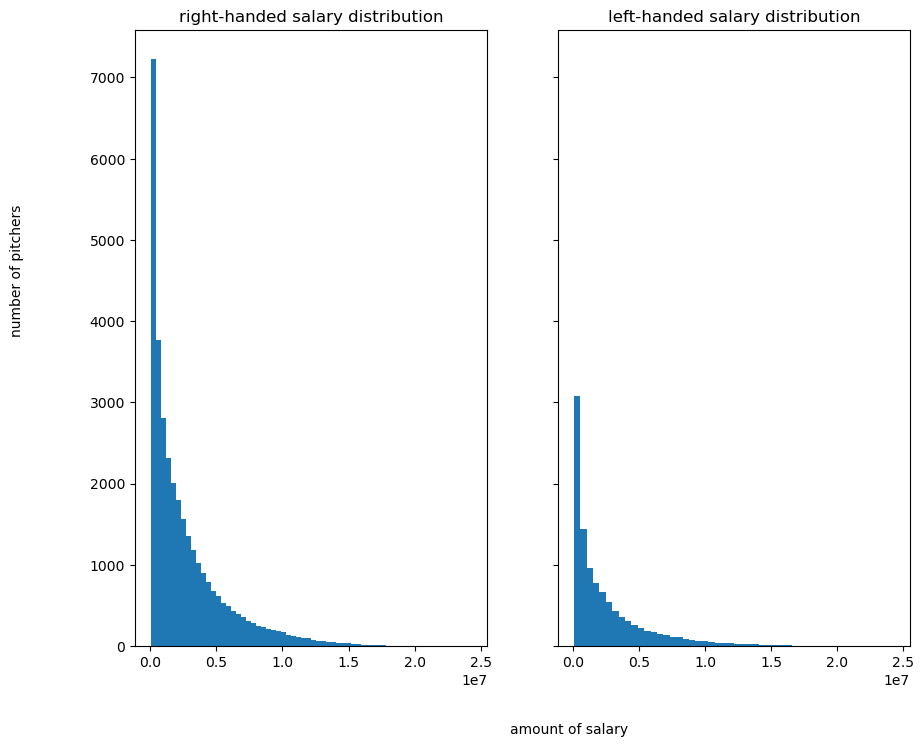

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (10,8))
ax[0].hist(r_salary_arrow, bins = 50, cumulative = -1)
ax[1].hist(l_salary_arrow, bins = 50, cumulative = -1)
ax[0].set_title('right-handed salary distribution')
ax[1].set_title('left-handed salary distribution')
fig.text(0.5,0, "amount of salary")
fig.text(0,0.5, "number of pitchers", rotation = 90)
plt.show()

**2.2 —** /Discuss:/ This plot has an issue which severely limits the amount of information one can draw from it. Describe the issue and propose a solution to address it.

both plots are right-skewed that they have long tails. From these plots we can lose useful information about tails(heavy tails might have more useful information about the data). As always log is our friends. In this case we have two options:
1)we should use Power Law which can tell more information about long haevy tail. we use log-log scale for axes. 
2)if it is exponential we use log scale only for y axis. 

**2.3 —** Implement the solution proposed by yourself in the previous question.

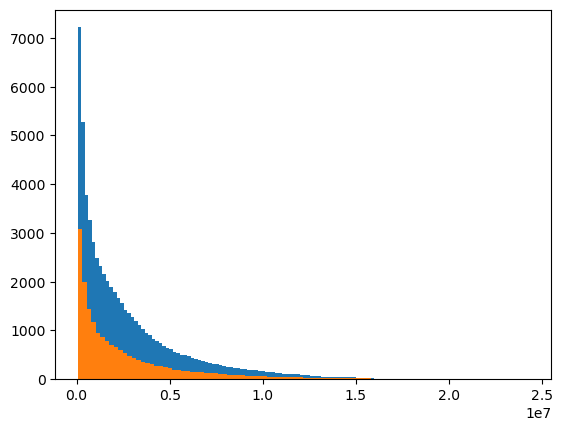

In [22]:
# let try the case that ccdf is power of x. we use log scale for both axes(x, y ) 
right_handed_array_50 = plt.hist(r_salary_arrow, bins = 100, cumulative = -1)
left_handed_array_50 = plt.hist(l_salary_arrow, bins = 100, cumulative = -1)

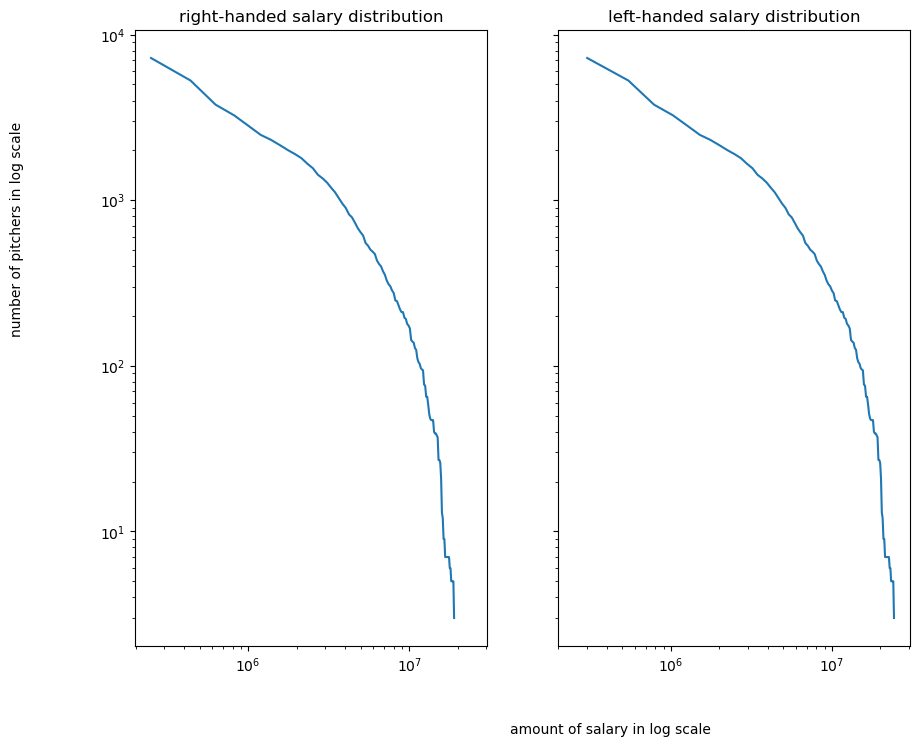

In [23]:
# loglog scale in both axes. 
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (10,8))
ax[0].loglog(right_handed_array_50[1][1:], right_handed_array_50[0])
ax[1].loglog(left_handed_array_50[1][1:],right_handed_array_50[0])
ax[0].set_title('right-handed salary distribution')
ax[1].set_title('left-handed salary distribution')
fig.text(0.5,0, "amount of salary in log scale")
fig.text(0,0.5, "number of pitchers in log scale", rotation = 90)
plt.show()

# we see that figures are not straight line. So ccdf is not power of x 

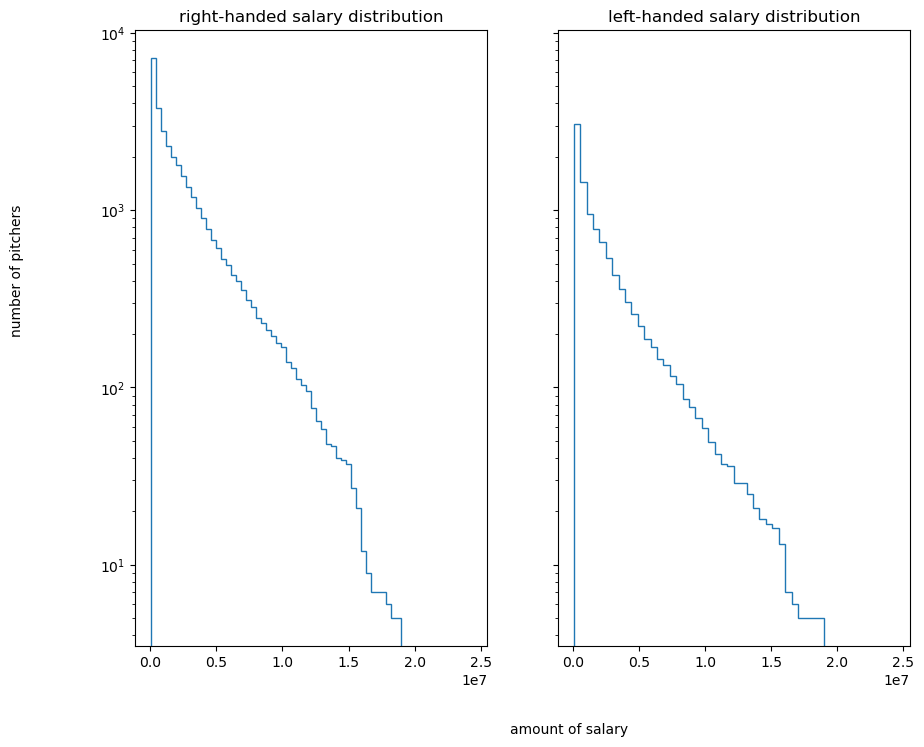

In [24]:
# lets try if ccdf is exp(x). 
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True, figsize = (10,8))
ax[0].hist(r_salary_arrow, bins = 50, cumulative = -1, log = True, histtype = 'step')
ax[1].hist(l_salary_arrow, bins = 50, cumulative = -1, log = True, histtype = 'step')
ax[0].set_title('right-handed salary distribution')
ax[1].set_title('left-handed salary distribution')
fig.text(0.5,0, "amount of salary")
fig.text(0,0.5, "number of pitchers", rotation = 90)
plt.show()

# we see that it is similar to straight line. y = C*exp(x) -> log(y) = c + x

In [25]:
# check if it is exponential distribution
print(diagnostic.kstest_normal(r_salary_arrow, dist = 'exp'))
print(diagnostic.kstest_normal(l_salary_arrow, dist = 'exp'))

#  since both p-values < 0.05 they are not exponential distribution

(0.24482471455373683, 0.0009999999999998899)
(0.23150109561239796, 0.0009999999999998899)


both p < 0.05 so they are  not exponential distribution. 

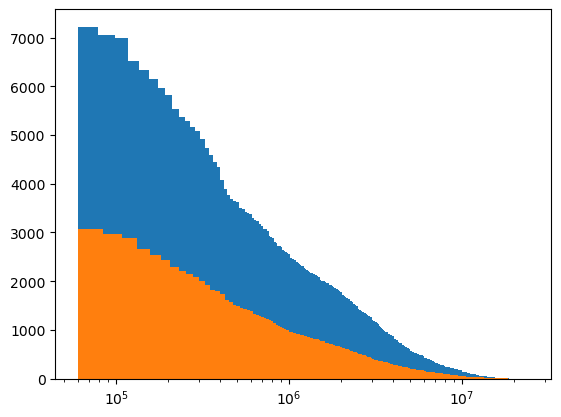

In [26]:
# let's plot in log-x scale
right_handed_array_50 = plt.hist(r_salary_arrow, bins = 1000, cumulative = -1, label = 'r-handed pitchers')
left_handed_array_50 = plt.hist(l_salary_arrow, bins = 1000, cumulative = -1, label = 'l-handed pitchers')
plt.xscale('log')

# in this plot we can see tails clearly

**2.4 —** /Discuss:/ Considering this second version of the plot, describe what the plot shows with regard to the distribution of salaries from left- and right-handed pitchers.

* this plot shows ccdf of left- and right-handed pitchers' salary in logarithmic x-axis. since we can see tails clearly, we can compare them. This plot shows that number of right-handed pitchers is twice as many left-handed pichers.

**2.5—** Calculate the mean and the 95% confidence interval for the salary of left-handed and right-handed pitchers aggregating data across all years. Print the estimates. Additionally, present the estimates and the confidence intervals in a [point plot](https://seaborn.pydata.org/_images/pointplot_7_0.png). Calculate your confidence intervals using the standard error of the mean and ignoring missing values.

In [27]:
l_m = l_df.salary.mean()
r_m = r_df.salary.mean()
print(f' mean for left-handed pitchers: {l_df.salary.mean()}')
print(f' mean for right-handed pitchers: {r_df.salary.mean()}')
r_std = np.std(r_df['salary'])/np.sqrt(len(r_df))
l_std = np.std(l_df['salary'])/np.sqrt(len(l_df))
print(f'95% confidence interval for the salary of light-handed pitchers: {(l_m - 2*l_std, l_m + 2*l_std)}')
print(f'95% confidence interval for the salary of right-handed pitchers: {(r_m - 2*r_std, r_m + 2*r_std)}')

 mean for left-handed pitchers: 1437232.861328125
 mean for right-handed pitchers: 1597010.1359545896
95% confidence interval for the salary of light-handed pitchers: (1350916.9209251183, 1523548.8017311317)
95% confidence interval for the salary of right-handed pitchers: (1538335.2007008244, 1655685.0712083548)


<Axes: xlabel='throws', ylabel='salary'>

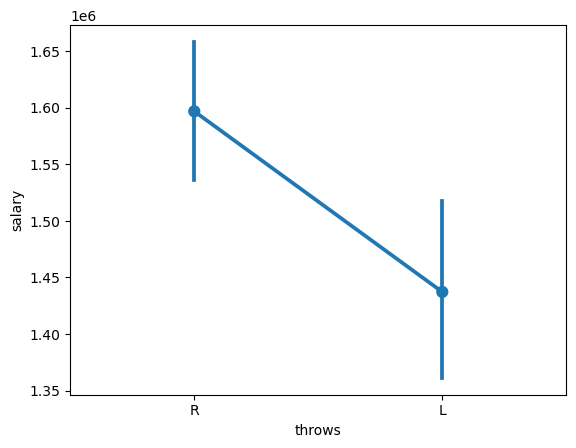

In [28]:
sns.pointplot(x = df['throws'], y = df['salary'])

**2.6 —** /Discuss:/ Can you tell whether the difference between the two distributions is statistically significant (at the .05 level of significance) from the image? Why?

* from the last plot we can say that there is statistically significant difference between two distributions. As you see confedencd intervals(CI = 0.95) are shown and there is no interception between CIs. 

**2.7 —** Perform a t-test test comparing the salaries of left-handed and right-handed pitchers at the .05 level of significance. Consider data from all years. /Discuss:/ Who earns more?

In [29]:
print(stats.ttest_ind(l_df['salary'], r_df['salary']))

TtestResult(statistic=-3.0106974397099378, pvalue=0.0026128052505378953, df=10293.0)


since p-value < 0.05, we can reject the null hypothesis that salaries are same. So there is statistically significant difference. since the mean of right-handed salary is more than that of left-handed, right-handed pitchers earn more

---

Now, let's turn to analyzing performance. A commonly used metric to evaluate the skill of a pitcher is to look at the batting average of the pitcher’s opponents. According to [Wikipedia](https://en.wikipedia.org/wiki/Batting_average_against),

> In baseball statistics, batting average against (denoted by BAA or AVG), also known as opponents' batting average (denoted by OBA), is a statistic that measures a pitcher's ability to prevent hits during official at bats. It can alternatively be described as the league's hitters' combined batting average against the pitcher.

The intuition is clear: if you are a pitcher, you do not want the batter actually to hit the ball. Thus, if you are a good pitcher, the opponent batter should miss a lot against you! Conveniently, this is already calculated on a yearly basis in our data.

---

**2.8 —** Considering data from all years, calculate the mean opponents' batting average for left- and right-handed pitchers. Run a t-test test to determine if this difference is statistically significant at the .05 level of significance. **Consider only pitchers in the years during which they have played atleast 5 games.** /Discuss:/ According to this approach, who are the better pitchers? Left-handed or right-handed pitchers?

In [30]:
r_df_copy = r_df.copy()
l_df_copy = l_df.copy()

r_df = r_df.dropna(subset = ['BAOpp', 'G'])
l_df = l_df.dropna(subset = ['BAOpp','G'])
r_df = r_df.query('G >= 5')
l_df = l_df.query('G >= 5')

print(f'mean opponents batting average for left-handed pitchers: {l_df.BAOpp.mean()}')
print(f'mean opponents batting average for right-handed pitchers: {r_df.BAOpp.mean()}')
print(stats.ttest_ind(l_df['BAOpp'], r_df['BAOpp']))

mean opponents batting average for left-handed pitchers: 0.2680601709401709
mean opponents batting average for right-handed pitchers: 0.265092157731502
TtestResult(statistic=3.068824914264002, pvalue=0.0021549600335275323, df=9694.0)




p-value = 0.002 < 0.05 -> we reject null hypothisis that BAOpps are same.So there is statistically significant difference between BAOpps. Comparing mean values of BAOpps we can say that left-handed pitcher better!



# Task 3 (18 pts)

Before you report your results to Mr. Russo, you decide to run them by your favorite Applied Data Analysis' TA, Ms. Sakota. She seems skeptical! According to her, you should take into account the time variable!

**3.1 —** Repeat the analysis from tasks 2.7 and 2.8 considering only data from the year 2000. That is, use a t-test to determine the distribution of salaries (2.7) and opponents' batting average (2.8) for all data of the year 2000 only. 

In [31]:
# 2.7 tasks for 2000 year
l_df_2000 = l_df_copy[l_df_copy['yearID'] == 2000]
r_df_2000 = r_df_copy[r_df_copy['yearID'] == 2000]
print(stats.ttest_ind(l_df_2000['salary'], r_df_2000['salary']))

TtestResult(statistic=-0.3682145722424321, pvalue=0.7128996415072697, df=418.0)


-- pvalue > 0.05 -> we failed reject null hypothesis that salaries are same. So there is no statistically significant difference between salaries. 

In [32]:
# 2.8 tasks for 2000 year
r_df_2000 = r_df_2000.dropna(subset = ['BAOpp', 'G'])
l_df_2000 = l_df_2000.dropna(subset = ['BAOpp','G'])
r_df_2000 = r_df_2000.query('G >= 5')
l_df_2000 = l_df_2000.query('G >= 5')

print(f'mean opponents batting average for left-handed pitchers: {l_df_2000.BAOpp.mean()}')
print(f'mean opponents batting average for right-handed pitchers: {r_df_2000.BAOpp.mean()}')
print(stats.ttest_ind(l_df_2000['BAOpp'], r_df_2000['BAOpp']))

mean opponents batting average for left-handed pitchers: 0.27414150943396226
mean opponents batting average for right-handed pitchers: 0.2712041522491349
TtestResult(statistic=0.5361058926583832, pvalue=0.5921886643320873, df=393.0)


p-value > 0.05 --> we failed to reject null hypothesis that BAOpps are same.So there is no statistically significant difference between BAOpps.

**3.2 —** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain three panels:
- Panel A: The percentage of left-handed pitchers per year;
- Panel B: The average salary of all pitchers per year
- Panel C: The average opponents' batting average of all pitchers per year.

Additionally, print, for the year 2007:
- the percentage of left-handed pitchers.
- the average salary.
- the average  opponents' batting average.

In [33]:
# the percentage of left-handed pitchers.
gr_year = df['yearID'].value_counts(ascending = True)
gr_year = gr_year.reset_index(name = 'number of pitchers')
year_left = df[df['throws'] == "L"]['yearID'].value_counts(ascending = True)
year_left = year_left.reset_index(name = 'number of left-handed')
year_left = year_left.merge(gr_year, how = 'left', on = 'yearID')
year_left['the percentage of left-handed pitchers'] = year_left['number of left-handed']/year_left['number of pitchers']*100
year_left = year_left.sort_values('yearID', ignore_index = True)

In [34]:
# The average salary of all pitchers per year
average_salary_per_year = df[['yearID', 'salary']].groupby('yearID').mean().reset_index()

In [35]:
# The average opponents' batting average of all pitchers per year.
average_BAOpp_per_year = df[['yearID', 'BAOpp']].groupby('yearID').mean().reset_index()


<Axes: xlabel='yearID'>

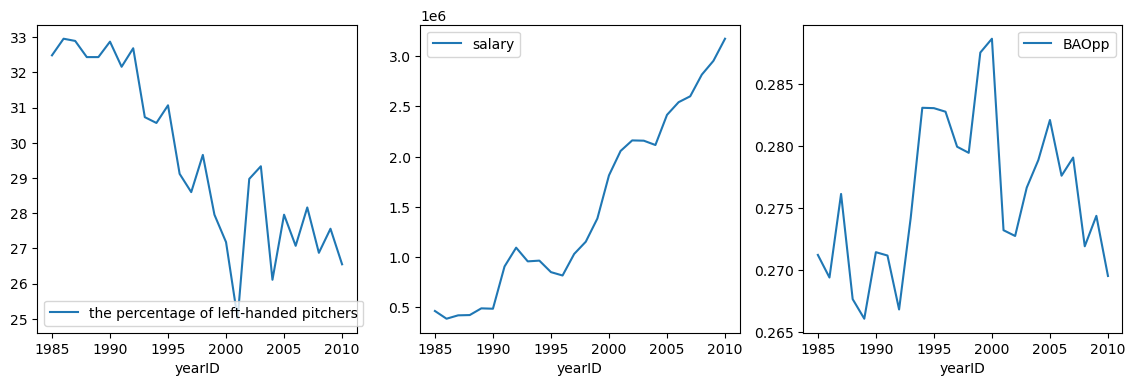

In [36]:
fig, ax = plt.subplots(1,3, figsize = (14,4))
year_left.plot(kind = 'line', x = 'yearID', y = 'the percentage of left-handed pitchers', ax = ax[0])
average_BAOpp_per_year.plot(x = 'yearID', y = 'BAOpp', ax = ax[2])
average_salary_per_year.plot(x = 'yearID', y = 'salary', ax = ax[1])

In [37]:
lf_per_2007 = year_left[year_left['yearID'] == 2007].loc[(22, 'the percentage of left-handed pitchers')]
print(f'the percentage of left-handed pitchers for 2007: {lf_per_2007}')
print(average_salary_per_year[average_salary_per_year['yearID'] == 2007])
print(average_BAOpp_per_year[average_BAOpp_per_year['yearID'] == 2007])

the percentage of left-handed pitchers for 2007: 28.160919540229884
    yearID        salary
22    2007  2.600514e+06
    yearID     BAOpp
22    2007  0.279046


**3.3 —** Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels: 
- Panel A: The average salary for left and right-handed pitchers per year, show 95% confidence intervals in your plot.
- Panel B: The average opponents' batting average for left and right-handed pitchers across the years, show 95% confidence intervals in your plot.


Additionally, print, for the year 1999:
- the average salary of left-handed pitchers.
- the average opponents' batting average of right-handed pitchers.

Text(0.5, 1.0, 'the average BAOpp of pitchers')

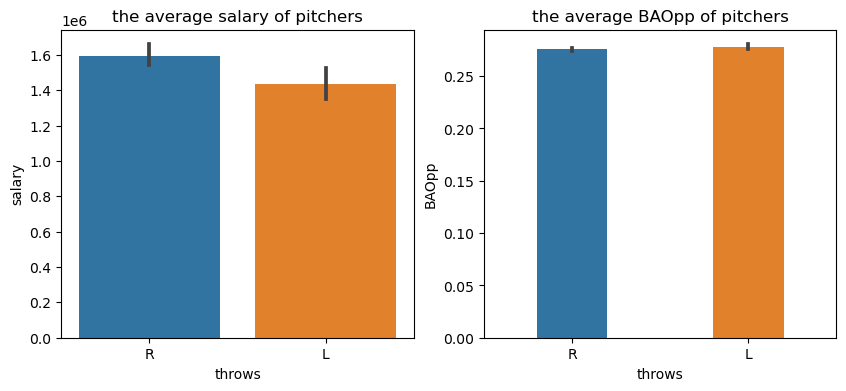

In [38]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
sns.barplot(x = df['throws'], y = df['salary'], ax = ax[0])
sns.barplot(x =df['throws'], y= df['BAOpp'], ax = ax[1] , width = 0.4)
ax[0].set_title('the average salary of pitchers')
ax[1].set_title('the average BAOpp of pitchers')

In [39]:
mask1 = df['yearID'] == 1999
mask2 = df['throws'] == 'L'
average_sal_left = df[mask1 & mask2]['salary'].mean()
print(f'the average salary of left-handed pitchers for 1999: {average_sal_left}')
mask3 = df['throws'] == 'R'
average_BAOpp = df[mask1 & mask3]['BAOpp'].mean()
print(f'the average opponents batting average of right-handed pitchers for 1999:  {average_BAOpp}')


the average salary of left-handed pitchers for 1999: 1272792.2753623188
the average opponents batting average of right-handed pitchers for 1999:  0.285780487804878


**3.4 —** /Discuss:/ Contrast the results obtained in Tasks 3.1 / 3.3 / 3.3 with the results obtained in Tasks 2.7 and 2.8. Are left-handed better than right-handed pitchers? Do they earn better salaries? Explain why the analysis might have reached different results.

* It seems that left-handed pitchers are similar to right-handed ones and earn similar salaries. The number of left handed pitchers has drastically decreased in the league (from ~33% in 1985 to ~26% in 2010), while salary and opponent batting average increased. This creates a simpson paradox that lead to the results in the previous analysis

**3.5 —** Before showing the final results to Mr. Russo, you pass them by Ms. Sakota once more. She looks happier now, but still looks a bit concerned. She asks you to perform a sanity check on the missing data for the period you are considering. Specifically, she is worried that there are significantly more missing salaries for left-handed pitchers or for right-handed pitchers.

- Create a plot with 10 inches of width and 4 inches of height. The plot should depict the fraction of missing salary  salary for left and right-handed pitchers per year, show 95% confidence intervals in your plot. 
- Print the fraction of left-handed pitchers with salary data missing for the year 2002. 
- /Discuss:/ According to the plot, are there significantly more missing salaries for left-handed pitchers?


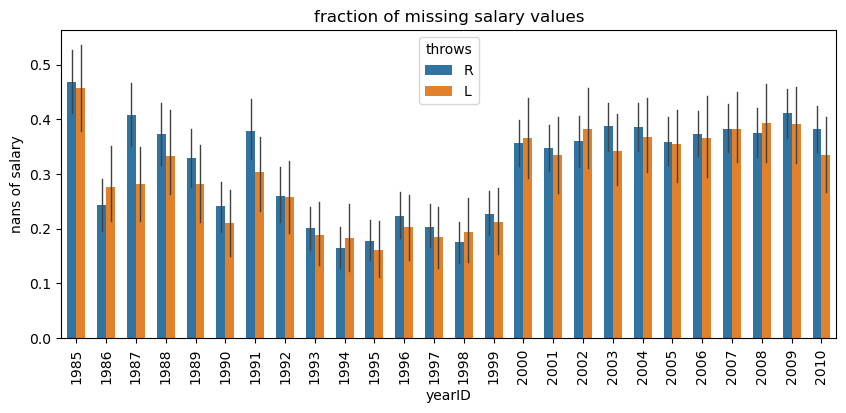

In [40]:
df['nans of salary'] = df['salary'].isnull()
fig, ax = plt.subplots(1,1, figsize = (10,4))
sns.barplot(data = df, x = 'yearID', y= 'nans of salary', hue ='throws', width = 0.6, errwidth = 1)
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
ax.set_title('fraction of missing salary values')
plt.show()

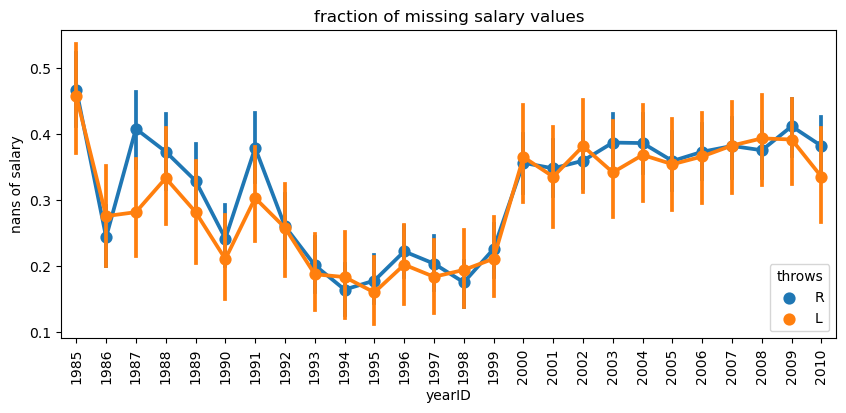

In [41]:
fig, ax = plt.subplots(1,1, figsize = (10,4))
sns.pointplot(data = df, x = 'yearID', y= 'nans of salary', hue ='throws')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
ax.set_title('fraction of missing salary values')
plt.show()

In [42]:
df_year_missing_salary = df[df['throws'] == 'L'].groupby('yearID')['nans of salary'].sum()
df_year_missing_salary = df_year_missing_salary.reset_index(name = 'nans')
n_of_allsalary = df[df['throws'] == 'L']['yearID'].value_counts().sort_index().reset_index(name = 'number of all salary values')
df_missing = df_year_missing_salary.merge(n_of_allsalary, how = 'left', on = 'yearID')
df_missing['fraction of missing'] = df_missing['nans']/df_missing['number of all salary values']
missing_2002 = df_missing[df_missing['yearID'] == 2002].loc[17, 'fraction of missing']
print(f'the fraction of left-handed pitchers with salary data missing for the year 2002: {missing_2002}')

the fraction of left-handed pitchers with salary data missing for the year 2002: 0.3817204301075269


*** According to the plot, fraction of missing salaries is almost same for both type of pitchers.

**3.6 –**  /Discuss:/ If 95% of the salaries of right-handed pitchers were missing and none for the left-handed pitchers, what problem could you envision could happen downstream when you analyzed the data?

* bias could happen in this case. Because most part of data for right_handed pitchers, our analysis might be biased.